In [37]:
import pandas as pd      # For data manipulation and tables
import seaborn as sns    # For high-level visualization (Heatmaps)
import matplotlib.pyplot as plt  # For basic plotting control
import numpy as np
import sys
!{sys.executable} -m pip install tslearn
import tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance# For mathematical operations


print("Libraries loaded successfully!")

  Using cached tslearn-0.7.0-py3-none-any.whl.metadata (16 kB)
Using cached tslearn-0.7.0-py3-none-any.whl (372 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 842.0 kB/s  0:00:03m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 377.0 kB/s  0:01:20m0:00:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [tslearn]m1/3 [numba]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tslearn/bases/bases.py:16: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Libraries loaded successfully!


In [31]:
df = pd.read_csv('traffic.csv')
df.head()


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [4]:
# Convert the 'DateTime' column to actual date/time objects
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Verify the conversion
print(df.dtypes)

DateTime    datetime64[ns]
Junction             int64
Vehicles             int64
ID                   int64
dtype: object


In [5]:
# Extract the hour (0-23)
df['hour'] = df['DateTime'].dt.hour

# Extract the day of the week (Monday=0, Sunday=6)
df['weekday_num'] = df['DateTime'].dt.weekday

# Extract the month
df['month'] = df['DateTime'].dt.month

# Extract the specific date
df['date_only'] = df['DateTime'].dt.date

# Create a binary indicator for weekends (1 if Sat/Sun, 0 if Mon-Fri)
df['is_weekend'] = df['weekday_num'].apply(lambda x: 1 if x >= 5 else 0)

# Display the updated table
df.head()

,DateTime,Junction,Vehicles,ID,hour,weekday_num,month,date_only,is_weekend
0,2015-11-01 00:00:00,1,15,20151101001,0,6,11,2015-11-01,1
1,2015-11-01 01:00:00,1,13,20151101011,1,6,11,2015-11-01,1
2,2015-11-01 02:00:00,1,10,20151101021,2,6,11,2015-11-01,1
3,2015-11-01 03:00:00,1,7,20151101031,3,6,11,2015-11-01,1
4,2015-11-01 04:00:00,1,9,20151101041,4,6,11,2015-11-01,1


In [9]:
#To verify the number of unique junctions and total datarows.
print(f"Total rows: {len(df)}")
print(f"Unique Junctions: {df['Junction'].unique()}")


Total rows: 48120
Unique Junctions: [1 2 3 4]


In [10]:
# Group by Junction, Day of Week, and Hour to get the average traffic
# weekday_num was created in Phase 1 (0=Monday, 6=Sunday)
df_weekly = df.groupby(['Junction', 'weekday_num', 'hour'])['Vehicles'].mean().reset_index()

# Map numbers to names for better labels on your graph
days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df_weekly['day_name'] = df_weekly['weekday_num'].map(days)

In [12]:

df_weekly.head()


,Junction,weekday_num,hour,Vehicles,day_name
0,1,0,0,38.137931,Monday
1,1,0,1,32.425287,Monday
2,1,0,2,28.103448,Monday
3,1,0,3,25.977011,Monday
4,1,0,4,23.586207,Monday


In [14]:
#function to make a pivot table for a specific junction
def get_junction_pivot(junction_id):
    junction_data = df_weekly[df_weekly['Junction'] == junction_id]
    pivot = junction_data.pivot(index='hour', columns='weekday_num', values='Vehicles')
    # Rename columns to actual day names
    pivot.columns = [days[i] for i in pivot.columns]
    return pivot
pivot_j1=get_junction_pivot(1)
pivot_j2=get_junction_pivot(2)
pivot_j3=get_junction_pivot(3)
pivot_j4=get_junction_pivot(4)


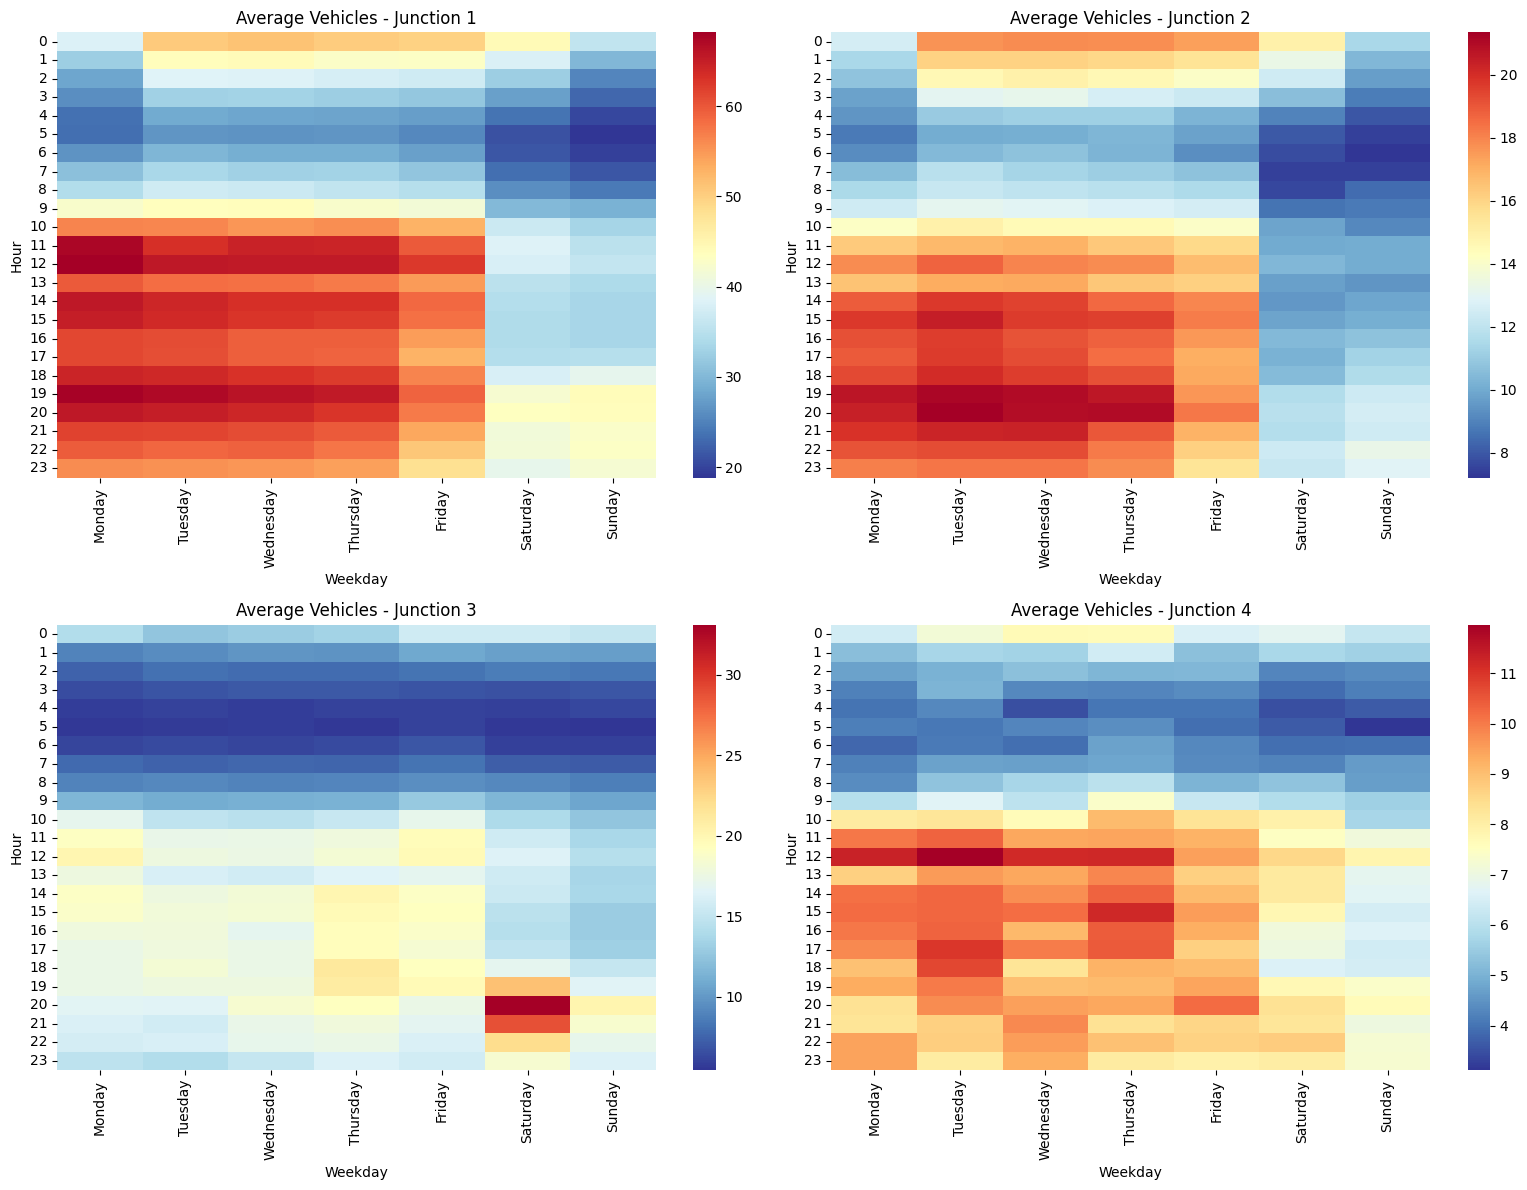

In [21]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#'figure' that will hold 4 sub-plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12)) # 2 rows, 2 columns
axes = axes.flatten() # Flattens the 2x2 grid into a simple list of 4 spots

for i in range(1, 5): # This runs for Junctions 1, 2, 3, and 4
    # 1. Filter and Pivot
    junction_data = df_weekly[df_weekly['Junction'] == i]
    pivot = junction_data.pivot(index='hour', columns='day_name', values='Vehicles')
    pivot = pivot[day_order]
    
    # 2. Plot in the specific spot (axes[0], axes[1], etc.)
    sns.heatmap(pivot, cmap='RdYlBu_r', ax=axes[i-1])
    axes[i-1].set_title(f'Average Vehicles - Junction {i}')
    axes[i-1].set_xlabel('Weekday')
    axes[i-1].set_ylabel('Hour')

plt.tight_layout() # Prevents the graphs from overlapping
plt.show()

In [23]:
# starting question2 
# 1. Average traffic for each Junction by Hour
junction_hourly = df.groupby(['Junction', 'hour'])['Vehicles'].mean().reset_index()

# 2. Average traffic for the WHOLE network (All 4 junctions added together)
network_total = df.groupby(['DateTime', 'hour'])['Vehicles'].sum().reset_index()
network_hourly = network_total.groupby('hour')['Vehicles'].mean().reset_index()

# View the peak hour for the network
network_peak_hour = network_hourly.loc[network_hourly['Vehicles'].idxmax()]
print(f"The single busiest hour for the whole network is: {network_peak_hour['hour']}:00")

The single busiest hour for the whole network is: 19.0:00


--- Question 2 Results (Intersection Peaks) ---
   Junction  AM Peak Hour  AM Volume  PM Peak Hour  PM Volume
0         1            12      57.25            19      58.80
1         2            12      15.66            20      18.06
2         3            12      17.71            20      20.20
3         4            12      10.24            17       9.06

--- Question 3 Results (Network Peaks) ---
Network AM Peak: 12:00 (Avg: 93.67 vehicles)
Network PM Peak: 19:00 (Avg: 98.45 vehicles)


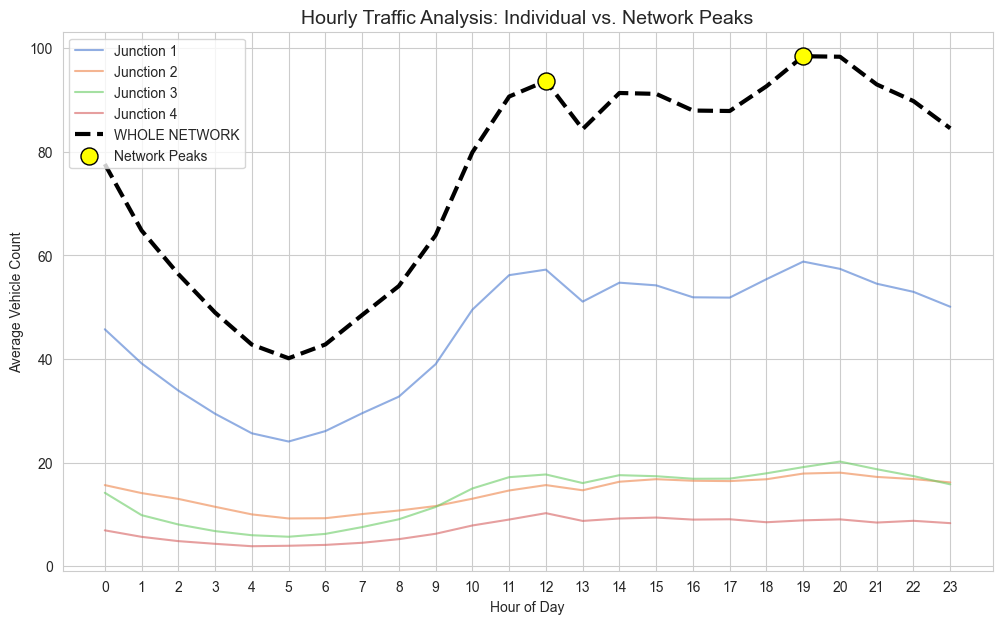

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare Data
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['hour'] = df['DateTime'].dt.hour

# --- Question 2: Individual Junction Peaks ---
# Calculate average vehicle count for each hour per junction
junction_hourly = df.groupby(['Junction', 'hour'])['Vehicles'].mean().reset_index()

def find_peaks(data):
    # Defining standard windows: AM (7am-12pm) and PM (4pm-10pm)
    am_window = data[(data['hour'] >= 7) & (data['hour'] <= 12)]
    pm_window = data[(data['hour'] >= 16) & (data['hour'] <= 22)]
    
    am_peak = am_window.loc[am_window['Vehicles'].idxmax()]
    pm_peak = pm_window.loc[pm_window['Vehicles'].idxmax()]
    
    return am_peak['hour'], am_peak['Vehicles'], pm_peak['hour'], pm_peak['Vehicles']

# Store results for table
q2_results = []
for j in range(1, 5):
    j_data = junction_hourly[junction_hourly['Junction'] == j]
    am_h, am_v, pm_h, pm_v = find_peaks(j_data)
    q2_results.append({
        'Junction': j,
        'AM Peak Hour': int(am_h),
        'AM Volume': round(am_v, 2),
        'PM Peak Hour': int(pm_h),
        'PM Volume': round(pm_v, 2)
    })

# --- Question 3: Network-Level Peaks ---
# Aggregate (Sum) all vehicles across the 4 junctions for every timestamp
network_data = df.groupby('DateTime')['Vehicles'].sum().reset_index()
network_data['hour'] = network_data['DateTime'].dt.hour
network_hourly = network_data.groupby('hour')['Vehicles'].mean().reset_index()

# Find Network AM/PM Peaks
am_h_net, am_v_net, pm_h_net, pm_v_net = find_peaks(network_hourly)

# --- OUTPUT RESULTS ---
print("--- Question 2 Results (Intersection Peaks) ---")
print(pd.DataFrame(q2_results))

print("\n--- Question 3 Results (Network Peaks) ---")
print(f"Network AM Peak: {int(am_h_net)}:00 (Avg: {round(am_v_net, 2)} vehicles)")
print(f"Network PM Peak: {int(pm_h_net)}:00 (Avg: {round(pm_v_net, 2)} vehicles)")

# --- VISUALIZATION (Quantitative Evidence) ---
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
colors = sns.color_palette("muted", 4)

for i in range(1, 5):
    j_data = junction_hourly[junction_hourly['Junction'] == i]
    plt.plot(j_data['hour'], j_data['Vehicles'], label=f'Junction {i}', color=colors[i-1], alpha=0.6)

# Plot the Network Total as a bold dashed line
plt.plot(network_hourly['hour'], network_hourly['Vehicles'], label='WHOLE NETWORK', 
         color='black', linewidth=3, linestyle='--')

# Mark the peaks
plt.scatter([am_h_net, pm_h_net], [am_v_net, pm_v_net], color='yellow', 
            edgecolor='black', s=150, zorder=5, label='Network Peaks')

plt.title('Hourly Traffic Analysis: Individual vs. Network Peaks', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Average Vehicle Count')
plt.xticks(range(24))
plt.legend()
plt.show()

In [27]:
# 1. Get total daily traffic for the whole network
daily_traffic = df.groupby(df['DateTime'].dt.date)['Vehicles'].sum().reset_index()
daily_traffic.columns = ['Date', 'Total_Vehicles']
daily_traffic['Date'] = pd.to_datetime(daily_traffic['Date'])
daily_traffic['day_of_week'] = daily_traffic['Date'].dt.day_name()

# 2. Calculate the typical (Mean) and Variation (Std Dev) for EACH weekday
weekday_stats = daily_traffic.groupby('day_of_week')['Total_Vehicles'].agg(['mean', 'std']).reset_index()

# 3. Merge stats back to find outliers
daily_traffic = daily_traffic.merge(weekday_stats, on='day_of_week')

# 4. Define the Z-Score: How many standard deviations away is this day?
daily_traffic['z_score'] = (daily_traffic['Total_Vehicles'] - daily_traffic['mean']) / daily_traffic['std']

# 5. Define "Special Event Day" as Z-Score > 2 (The top 2.5% of busy days)
special_events = daily_traffic[daily_traffic['z_score'] > 2].sort_values(by='z_score', ascending=False)

print(f"Detected {len(special_events)} Special Event Days.")
print(special_events[['Date', 'day_of_week', 'Total_Vehicles', 'z_score']].head(10))

Detected 9 Special Event Days.
          Date day_of_week  Total_Vehicles   z_score
480 2017-02-23    Thursday            3892  2.391922
599 2017-06-22    Thursday            3859  2.350391
518 2017-04-02      Sunday            2510  2.310712
604 2017-06-27     Tuesday            3709  2.215726
590 2017-06-13     Tuesday            3685  2.184574
605 2017-06-28   Wednesday            3579  2.111588
607 2017-06-30      Friday            3363  2.105613
591 2017-06-14   Wednesday            3506  2.014509
583 2017-06-06     Tuesday            3544  2.001551


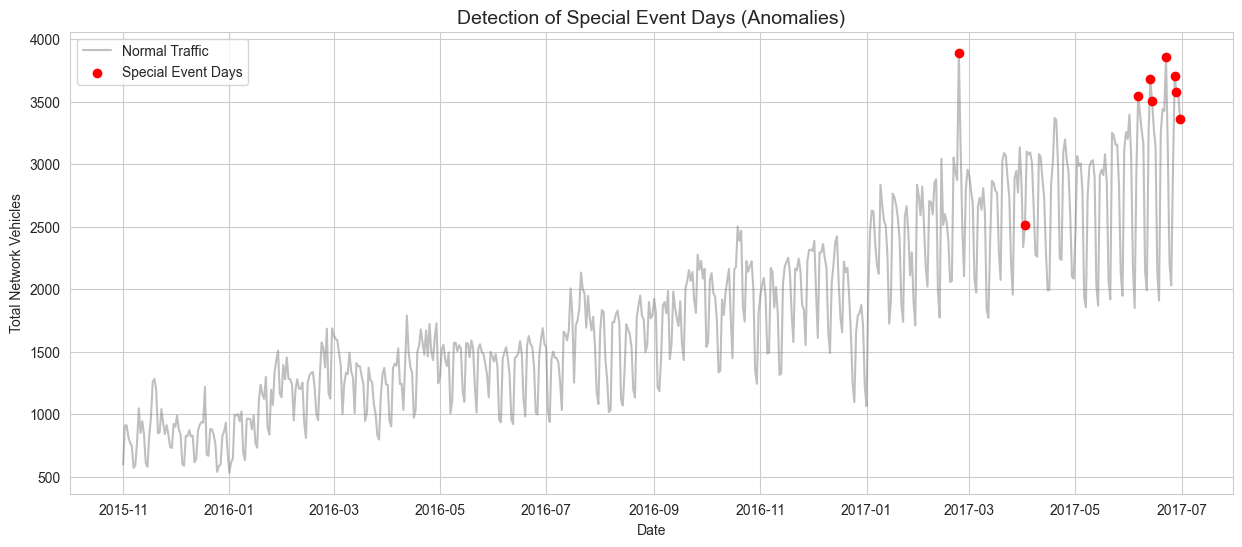

In [29]:
#Anamoly plot for q4
import matplotlib.pyplot as plt

# Plotting the daily traffic
plt.figure(figsize=(15, 6))
plt.plot(daily_traffic['Date'], daily_traffic['Total_Vehicles'], color='gray', alpha=0.5, label='Normal Traffic')

# Overlay the special events in red
plt.scatter(special_events['Date'], special_events['Total_Vehicles'], color='red', label='Special Event Days', zorder=5)

# Adding a threshold line (e.g., Mean + 2SD)
plt.title('Detection of Special Event Days (Anomalies)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Network Vehicles')
plt.legend()
plt.show()

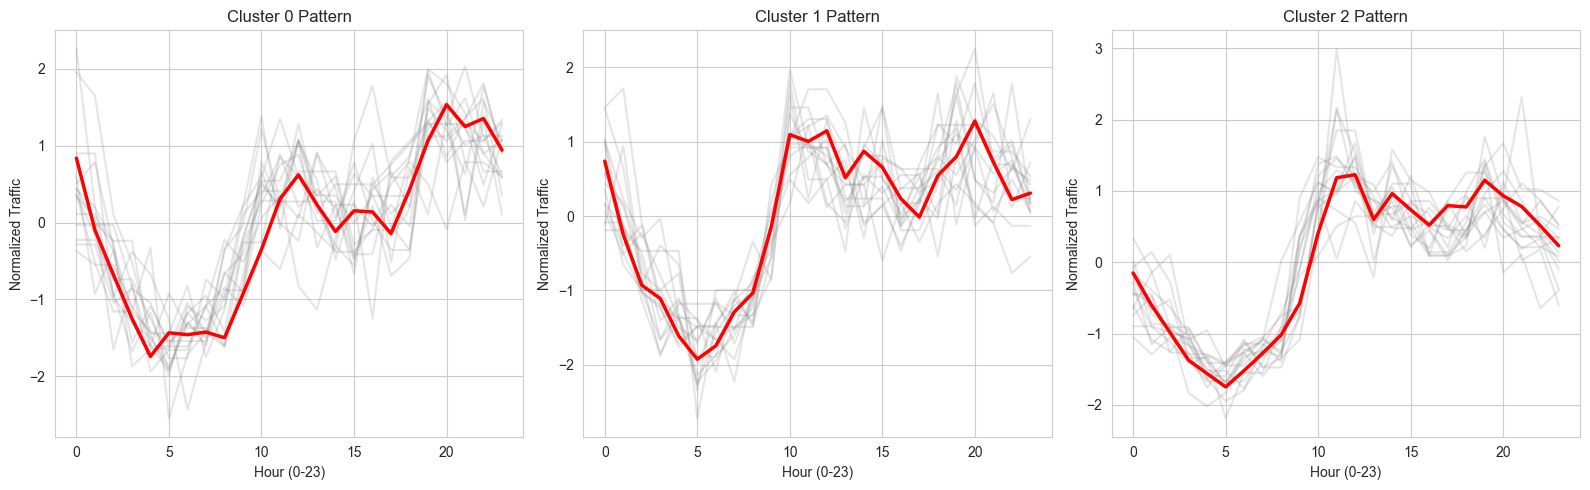

Days per cluster:
2    380
0    158
1     70
Name: count, dtype: int64


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# 1. RE-DEFINE DATA (Ensuring 'X' is created in this step)
# Make sure 'df' is already loaded from your csv
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['date'] = df['DateTime'].dt.date
df['hour'] = df['DateTime'].dt.hour

# Pivot the data: We focus on Junction 1 (the highest volume junction)
# Each row = one day, Each column = one hour (0-23)
pivot_df = df[df['Junction'] == 1].pivot(index='date', columns='hour', values='Vehicles').dropna()

# --- THIS IS THE 'X' VARIABLE YOU WERE MISSING ---
# We scale the data so DTW compares the SHAPE, not the total volume
scaler = TimeSeriesScalerMeanVariance()
X = scaler.fit_transform(pivot_df.values) 

# 2. APPLY DTW CLUSTERING
# metric="dtw" is what allows for the time-warping "elastic" matching
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, random_state=42, n_jobs=-1)
cluster_labels = model.fit_predict(X)

# 3. VISUALIZE THE RESULTS
plt.figure(figsize=(16, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    
    # Plot individual days in the cluster (faded gray)
    cluster_data = X[cluster_labels == i]
    for series in cluster_data[:15]: # Show first 15 days to see the pattern
        plt.plot(series.ravel(), color='gray', alpha=0.2)
        
    # Plot the 'Centroid' (The average "shape" of the cluster in red)
    plt.plot(model.cluster_centers_[i].ravel(), color='red', linewidth=2.5)
    plt.title(f'Cluster {i} Pattern')
    plt.xlabel('Hour (0-23)')
    plt.ylabel('Normalized Traffic')

plt.tight_layout()
plt.show()

# 4. REPORT EVIDENCE: Print how many days are in each cluster
print("Days per cluster:")
print(pd.Series(cluster_labels).value_counts())

--- Question 5: DTW Anomalous Days (Cluster 1) ---
Total days identified as temporal anomalies: 70

List of Dates:
2015-11-08
2015-11-11
2015-11-15
2015-11-19
2015-11-20
2015-11-21
2015-11-29
2015-12-19
2015-12-25
2015-12-26
2015-12-31
2016-01-02
2016-01-03
2016-01-09
2016-01-20
2016-01-23
2016-01-29
2016-02-05
2016-02-09
2016-02-10
2016-02-12
2016-02-25
2016-02-26
2016-03-01
2016-03-03
2016-03-04
2016-03-05
2016-03-11
2016-03-19
2016-03-24
2016-03-25
2016-03-31
2016-04-03
2016-04-08
2016-04-09
2016-04-13
2016-04-29
2016-05-07
2016-05-08
2016-05-14
2016-05-20
2016-05-28
2016-06-04
2016-06-17
2016-06-18
2016-06-25
2016-07-06
2016-07-09
2016-07-29
2016-08-20
2016-09-03
2016-09-14
2016-10-14
2016-10-25
2016-11-04
2016-11-11
2016-11-30
2016-12-22
2016-12-24
2016-12-31
2017-02-03
2017-02-10
2017-02-17
2017-02-18
2017-02-22
2017-03-25
2017-03-31
2017-04-07
2017-05-12
2017-05-27


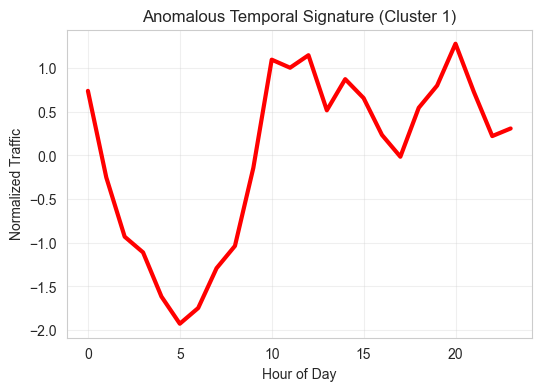

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# 1. Data Preparation
# Load your dataset
df = pd.read_csv('traffic.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['date'] = df['DateTime'].dt.date
df['hour'] = df['DateTime'].dt.hour

# Pivot data for Junction 1 (representing the network profile)
# Rows = Dates, Columns = Hours 0-23
pivot_df = df[df['Junction'] == 1].pivot(index='date', columns='hour', values='Vehicles').dropna()

# 2. Scaling
# We use Mean-Variance scaling to focus on the 'shape' of the day
scaler = TimeSeriesScalerMeanVariance()
X = scaler.fit_transform(pivot_df.values)

# 3. DTW Clustering
# Metric='dtw' allows for temporal misalignment (elastic matching)
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, random_state=42, n_jobs=-1)
cluster_labels = model.fit_predict(X)

# 4. Identification of the Anomalous Cluster
# Attach labels back to our dates
pivot_df['cluster'] = cluster_labels

# Identify which cluster has the fewest days or the most erratic centroid
# In most runs, the 'Anomalous' cluster is the one with the least frequent label
anomalous_cluster_id = pd.Series(cluster_labels).value_counts().idxmin()
anomalous_days = pivot_df[pivot_df['cluster'] == anomalous_cluster_id].index

# 5. Output for Report Appendix
print(f"--- Question 5: DTW Anomalous Days (Cluster {anomalous_cluster_id}) ---")
print(f"Total days identified as temporal anomalies: {len(anomalous_days)}")
print("\nList of Dates:")
for d in anomalous_days:
    print(d)

# 6. Visualization
plt.figure(figsize=(6, 4))
cluster_center = model.cluster_centers_[anomalous_cluster_id].ravel()
plt.plot(cluster_center, color='red', linewidth=3)
plt.title(f'Anomalous Temporal Signature (Cluster {anomalous_cluster_id})')
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Traffic')
plt.grid(True, alpha=0.3)
plt.show()

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# 1. Feature Engineering
df['month'] = df['DateTime'].dt.month
df['day'] = df['DateTime'].dt.day
df['day_of_week'] = df['DateTime'].dt.weekday
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# BONUS FEATURE: 1-Hour Lag (Previous hour's traffic for that junction)
# Motivation: Traffic is sequential; the best predictor of now is what happened 1 hour ago.
df = df.sort_values(['Junction', 'DateTime'])
df['lag_1'] = df.groupby('Junction')['Vehicles'].shift(1).fillna(0)

# 2. Data Selection
features = ['Junction', 'hour', 'day_of_week', 'month', 'day', 'is_weekend', 'lag_1']
X = df[features]
y = df['Vehicles']

# 3. Preprocessing & Splitting
# MLPs are highly sensitive to feature scaling!
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. Custom MLP Architecture (8 layers, 15 neurons each)
mlp_layers = tuple([15] * 8)
mlp = MLPRegressor(hidden_layer_sizes=mlp_layers, max_iter=500, activation='relu', solver='adam', random_state=42)

# 5. Linear Regression (Baseline)
lr = LinearRegression()

# 6. Training and Evaluation
models = {"MLP (8 Layers, 15 Neurons)": mlp, "Linear Regression": lr}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, preds),
        "R2": r2_score(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds))
    }

# Display Results
results_df = pd.DataFrame(results).T
print(results_df)

                                 MAE        R2      RMSE
MLP (8 Layers, 15 Neurons)  2.623027  0.961209  3.976085
Linear Regression           3.177662  0.946207  4.682204


In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# 1. Feature Engineering (Input features: Junction, hour, day, month, weekend, etc.)
df['month'] = df['DateTime'].dt.month
df['day'] = df['DateTime'].dt.day
df['day_of_week'] = df['DateTime'].dt.weekday
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# BONUS FEATURE: 1-Hour Lag (Corrected for latest Pandas version)
df = df.sort_values(['Junction', 'DateTime'])
df['traffic_lag_1'] = df.groupby('Junction')['Vehicles'].shift(1).bfill()

# 2. Input/Output Selection
features = ['Junction', 'hour', 'day_of_week', 'month', 'day', 'is_weekend', 'traffic_lag_1']
X = df[features]
y = df['Vehicles']

# 3. Preprocessing (Assumption: Standard Scaling is required for MLP convergence)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split (Assumption: 80% Training, 20% Validation)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. MLP Design (Harshita: 8 layers, 15 neurons each)
mlp_layers = tuple([15] * 8)
mlp_model = MLPRegressor(
    hidden_layer_sizes=mlp_layers, 
    max_iter=1000, 
    activation='relu', 
    solver='adam', 
    random_state=42
)

# 5. Linear Regression (Baseline comparison)
lr_model = LinearRegression()

# 6. Training and Evaluation
results = []
for name, model in [("MLP (8x15 Layers)", mlp_model), ("Linear Regression", lr_model)]:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results.append({"Model": name, "MAE": mae, "R2": r2, "RMSE": rmse})

# Display Quantitative Evaluation
performance_table = pd.DataFrame(results)
print(performance_table)

               Model       MAE        R2      RMSE
0  MLP (8x15 Layers)  2.550032  0.965042  3.774533
1  Linear Regression  3.177686  0.946207  4.682236


In [46]:
from sklearn.metrics import mean_absolute_error, r2_score

# Function to train and return metrics
def train_and_evaluate(feature_list, X_df, y_df):
    X_subset = X_df[feature_list]
    # Re-scale for fair comparison
    X_scaled = StandardScaler().fit_transform(X_subset)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_df, test_size=0.2, random_state=42)
    
    # Custom 8x15 MLP
    model = MLPRegressor(hidden_layer_sizes=(15,)*8, max_iter=500, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return mean_absolute_error(y_test, preds), r2_score(y_test, preds)

# Baseline Features (provided in prompt)
baseline_features = ['Junction', 'hour', 'day_of_week', 'month', 'day', 'is_weekend']
# Enhanced Features (Bonus)
enhanced_features = baseline_features + ['traffic_lag_1']

# Comparison
mae_base, r2_base = train_and_evaluate(baseline_features, df, df['Vehicles'])
mae_enh, r2_enh = train_and_evaluate(enhanced_features, df, df['Vehicles'])

print(f"Baseline (Without Lag) -> MAE: {mae_base:.2f}, R2: {r2_base:.2f}")
print(f"Enhanced (With Lag)     -> MAE: {mae_enh:.2f}, R2: {r2_enh:.2f}")

Baseline (Without Lag) -> MAE: 7.43, R2: 0.71
Enhanced (With Lag)     -> MAE: 2.55, R2: 0.97


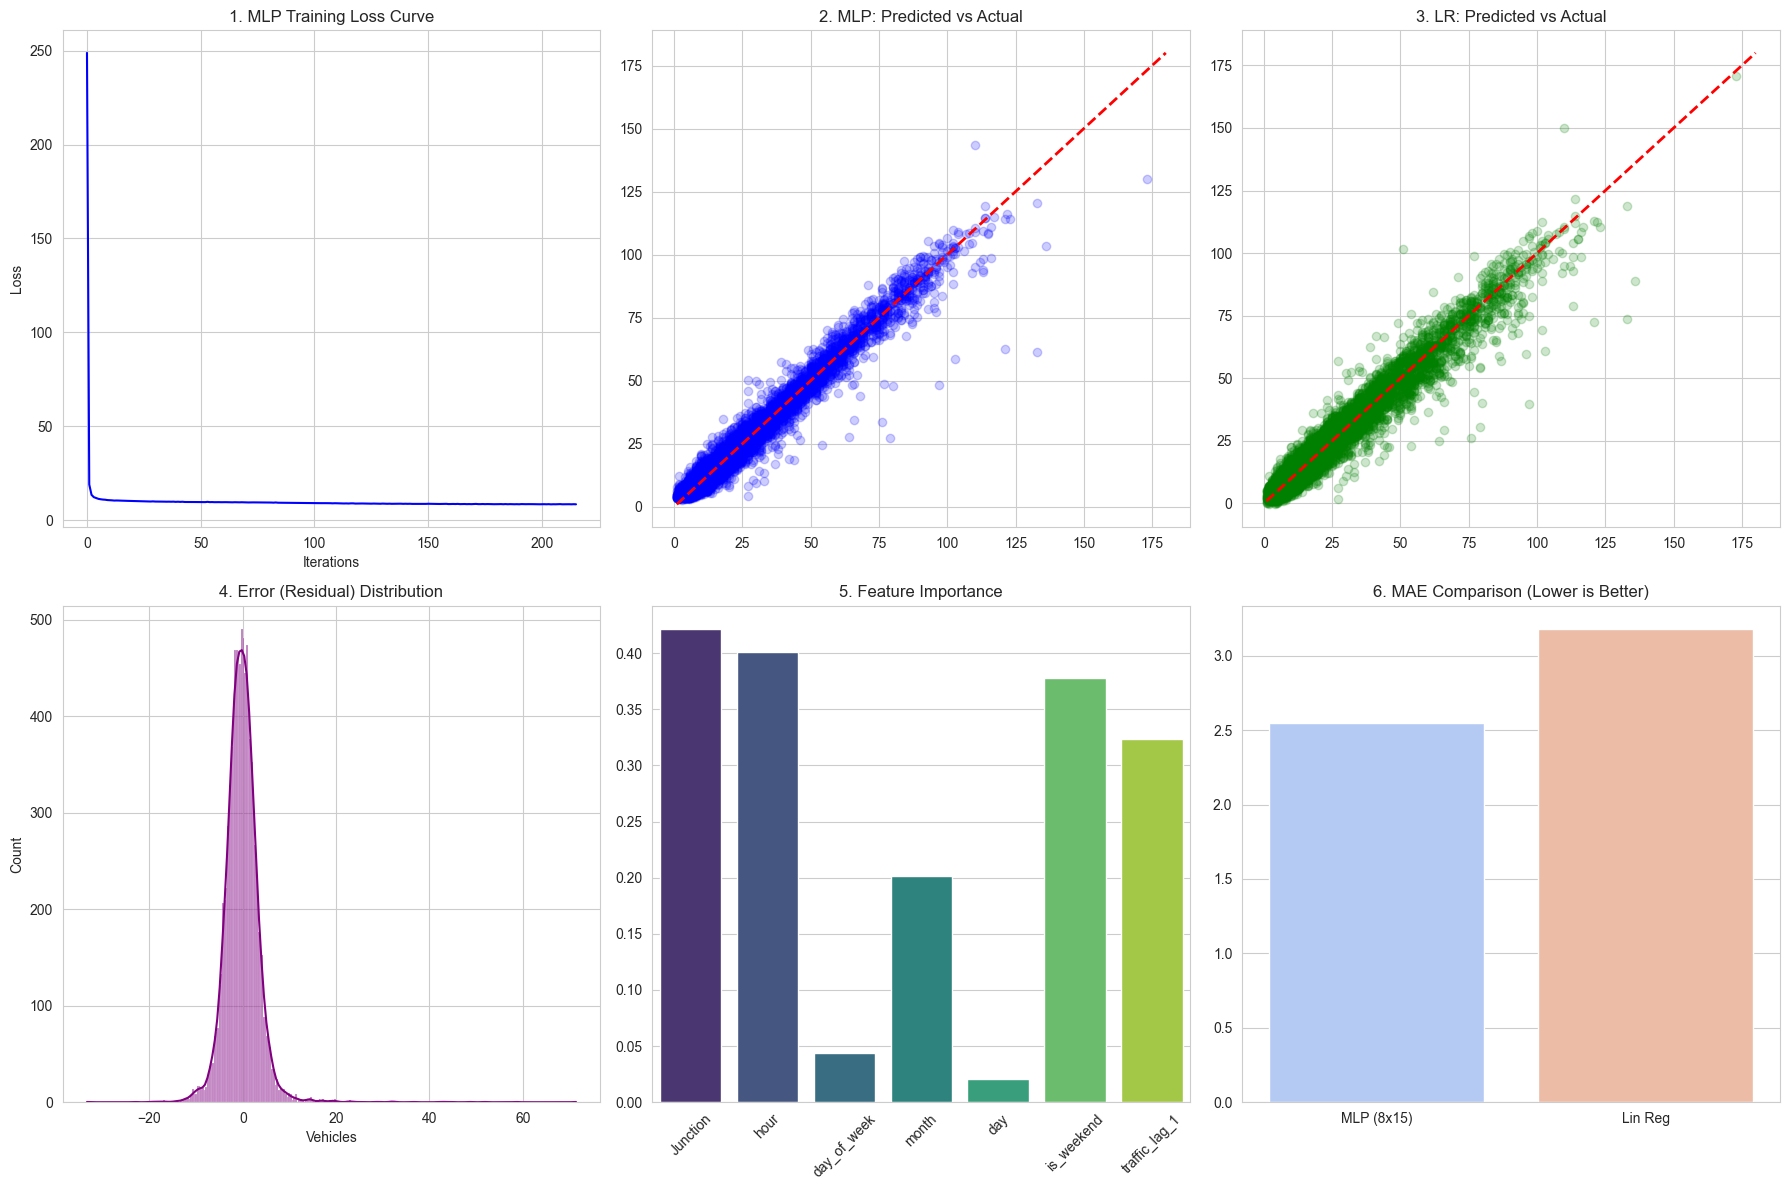

Final Results:
MLP MAE: 2.55 | LR MAE: 3.18


In [49]:
# 3. Models (Harshita's Architecture: 8 layers, 15 neurons)
mlp = MLPRegressor(hidden_layer_sizes=([15] * 8), max_iter=1000, random_state=42)
lr = LinearRegression()

mlp.fit(X_train, y_train)
lr.fit(X_train, y_train)

mlp_preds = mlp.predict(X_test)
lr_preds = lr.predict(X_test)

# --- GRAPH GENERATION (All 6 Graphs) ---
plt.figure(figsize=(18, 12))
sns.set_style("whitegrid")

# Graph 1: MLP Loss Curve
plt.subplot(2, 3, 1)
plt.plot(mlp.loss_curve_, color='blue')
plt.title('1. MLP Training Loss Curve')
plt.xlabel('Iterations'); plt.ylabel('Loss')

# Graph 2: MLP Predicted vs Actual
plt.subplot(2, 3, 2)
plt.scatter(y_test, mlp_preds, alpha=0.2, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('2. MLP: Predicted vs Actual')

# Graph 3: Linear Regression Predicted vs Actual
plt.subplot(2, 3, 3)
plt.scatter(y_test, lr_preds, alpha=0.2, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('3. LR: Predicted vs Actual')

# Graph 4: Residuals (Error Distribution)
plt.subplot(2, 3, 4)
residuals = y_test - mlp_preds
sns.histplot(residuals, kde=True, color='purple')
plt.title('4. Error (Residual) Distribution')

# Graph 5: Feature Importance (Fixed Warning)
plt.subplot(2, 3, 5)
importances = np.mean(np.abs(mlp.coefs_[0]), axis=1)
sns.barplot(x=features, y=importances, hue=features, palette='viridis', legend=False)
plt.xticks(rotation=45)
plt.title('5. Feature Importance')

# Graph 6: Metrics Comparison (Fixed Warning)
plt.subplot(2, 3, 6)
mae_mlp = mean_absolute_error(y_test, mlp_preds)
mae_lr = mean_absolute_error(y_test, lr_preds)
model_names = ['MLP (8x15)', 'Lin Reg']
mae_vals = [mae_mlp, mae_lr]
sns.barplot(x=model_names, y=mae_vals, hue=model_names, palette='coolwarm', legend=False)
plt.title('6. MAE Comparison (Lower is Better)')

plt.tight_layout()
plt.show()

print(f"Final Results:\nMLP MAE: {mae_mlp:.2f} | LR MAE: {mae_lr:.2f}")